### In this file, I'm going to build a CNN model to classify audio genres.

**IMPORTING LIBRARIES**

In [70]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import random
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

# `preprocess_and_load` Function

## Description
The `preprocess_and_load` function processes audio files from multiple genres, converts them into normalized log-scaled Mel spectrograms suitable for CNN input, and visualizes a random spectrogram to verify correctness.

   **Process Each Audio File**:
   - Load each `.wav` file with a fixed sample rate and duration.
   - Pad or truncate the audio to ensure consistent length.
   - Generate a Mel spectrogram using `librosa`.
   - Convert the spectrogram to decibel (log) scale.
   - Normalize the spectrogram to have zero mean and unit variance.
   - Append the normalized spectrogram and its label to the respective lists.

   **Return Processed Data**:
   - `spectrograms`: Array of Mel spectrograms.
   - `labels`: Array of numerical labels.
   - `genre_names`: List of genre names corresponding to labels.


C:\Users\-\AppData\Local\Temp\ipykernel_32120\1498276064.py:21: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sample_rate, duration=30)


Error processing data/genres_original/jazz\jazz.00054.wav: 


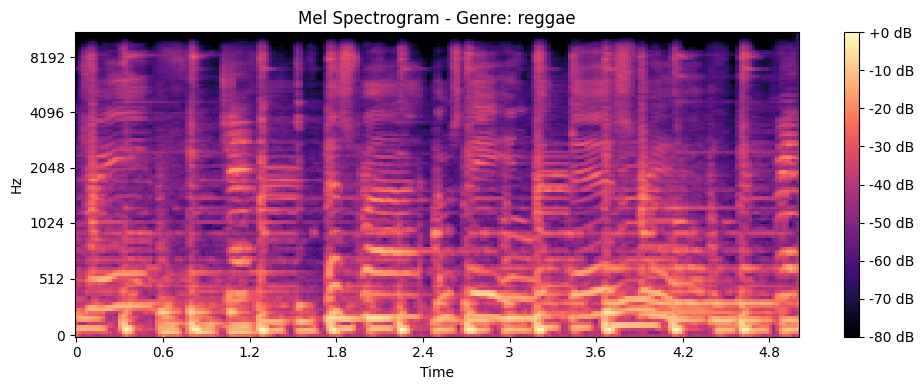

Processed 5985 files across 10 genres.
Shape of spectrograms: (5985, 128, 216, 1)


In [71]:
def preprocess_and_load(base_directory, sample_rate=22050):
    spectrograms = []
    labels = []
    genre_names = []
    
    # Calculate samples for 5 seconds
    samples_per_segment = 5 * sample_rate
    
    genres = [d for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]
    genres.sort()
    
    for label, genre in enumerate(genres):
        genre_dir = os.path.join(base_directory, genre)
        genre_names.append(genre)
        
        for file in os.listdir(genre_dir):
            if file.lower().endswith('.wav'):
                file_path = os.path.join(genre_dir, file)
                try:
                    # Load 30 seconds of audio
                    y, sr = librosa.load(file_path, sr=sample_rate, duration=30)
                    
                    # Split into 5-second segments
                    for i in range(0, len(y), samples_per_segment):
                        segment = y[i:i + samples_per_segment]
                        if len(segment) == samples_per_segment:  # Only use complete segments
                            # Create mel spectrogram with default parameters
                            mel_spect = librosa.feature.melspectrogram(y=segment, sr=sr)
                            mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)
                            
                            spectrograms.append(mel_spect_db)
                            labels.append(label)
                            
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
    
    spectrograms = np.array(spectrograms)[..., np.newaxis]
    labels = np.array(labels)
    
    # Plot a random spectrogram
    if spectrograms.size > 0:
        idx = random.randint(0, spectrograms.shape[0] - 1)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(spectrograms[idx].squeeze(), sr=sample_rate, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel Spectrogram - Genre: {genre_names[labels[idx]]}')
        plt.tight_layout()
        plt.show()
    
    return spectrograms, labels, genre_names

# Usage
base_dataset_directory = "data/genres_original/"
mel_spectrograms, labels, genre_names = preprocess_and_load(base_dataset_directory)

print(f"Processed {mel_spectrograms.shape[0]} files across {len(genre_names)} genres.")
print(f"Shape of spectrograms: {mel_spectrograms.shape}")

The preprocessing is done. Now we can build the CNN model with Pytorch


In [72]:
# Import PyTorch
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torchvision
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm


print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124


In [73]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device



'cuda'

In [74]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(mel_spectrograms, labels, test_size=0.2, random_state=69)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((4788, 128, 216, 1), (1197, 128, 216, 1), (4788,), (1197,))

In [75]:
# Convert the data to tensors
X_train = torch.from_numpy(X_train).permute(0, 3, 1, 2).to(device)  # Reshape to [batch, channel, height, width]
X_test = torch.from_numpy(X_test).permute(0, 3, 1, 2).to(device)
y_train = torch.from_numpy(y_train).long().to(device)
y_test = torch.from_numpy(y_test).long().to(device)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape



(torch.Size([4788, 1, 128, 216]),
 torch.Size([1197, 1, 128, 216]),
 torch.Size([4788]),
 torch.Size([1197]))

In [76]:
X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype


(torch.float32, torch.float32, torch.int64, torch.int64)

In [77]:
# DataLoader
BATCH_SIZE = 64

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape



(torch.Size([64, 1, 128, 216]), torch.Size([64]))

In [78]:
# See Dataloader content
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [79]:
def train_step(model, dataLoader, loss_fn, optimizer, accuracy_fn, device=device):
    train_loss, train_acc = 0, 0
    model.train()
    
    # Use tqdm for progress bar
    for batch, (X, y) in enumerate(tqdm(dataLoader)):
        X, y = X.to(device), y.to(device)
        
        # Forward pass
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Accumulate metrics
        train_loss += loss.item()
        acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        train_acc += acc
        
    # Calculate average loss and accuracy
    train_loss /= len(dataLoader)
    train_acc /= len(dataLoader)
    
    return train_loss, train_acc

In [80]:
def test_step(model, dataLoader, loss_fn, accuracy_fn, device=device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()
    
    with torch.inference_mode():
        for X, y in dataLoader:
            X, y = X.to(device), y.to(device)
            
            # Forward pass
            test_pred = model(X)
            
            # Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y).item()  # Add .item()
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1)
            )
        
        # Adjust metrics by dividing by the number of batches
        test_loss /= len(dataLoader)
        test_acc /= len(dataLoader)
        
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")
    
    return test_loss, test_acc

In [81]:
class AudioCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        
        # First Convolutional Block
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )
        
        # Second Convolutional Block
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )
        
        # Third Convolutional Block
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )
        
        # Fourth Convolutional Block
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )
        
        # Calculate flatten size dynamically
        self._initialize_flatten_size()
        
        # Fully Connected layers
        self.fc = nn.Sequential(
            nn.Linear(self.flatten_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def _initialize_flatten_size(self):
        x = torch.randn(1, 1, 128, 216)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        self.flatten_size = x.shape[1] * x.shape[2] * x.shape[3]
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Create model instance
model = AudioCNN(num_classes=len(genre_names))
model = model.to(device)

In [82]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001, weight_decay=1e-4)


In [83]:
# Training the Model

torch.manual_seed(69)

epochs = 50
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    train_step(model, train_dataloader, loss_fn, optimizer, accuracy_fn)
    test_step(model, test_dataloader, loss_fn, accuracy_fn)

Epoch 1
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 4.45476 | Test accuracy: 12.76%
Epoch 2
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 1.85319 | Test accuracy: 32.66%
Epoch 3
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 1.68284 | Test accuracy: 38.29%
Epoch 4
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 1.45695 | Test accuracy: 46.47%
Epoch 5
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 1.43473 | Test accuracy: 49.74%
Epoch 6
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 1.15114 | Test accuracy: 60.83%
Epoch 7
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 1.25345 | Test accuracy: 56.79%
Epoch 8
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 1.77207 | Test accuracy: 44.01%
Epoch 9
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 1.36324 | Test accuracy: 52.11%
Epoch 10
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 1.11022 | Test accuracy: 64.22%
Epoch 11
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 1.11047 | Test accuracy: 61.07%
Epoch 12
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.88098 | Test accuracy: 71.44%
Epoch 13
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.96702 | Test accuracy: 65.96%
Epoch 14
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.89751 | Test accuracy: 67.82%
Epoch 15
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.84561 | Test accuracy: 71.32%
Epoch 16
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.95771 | Test accuracy: 66.58%
Epoch 17
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.89501 | Test accuracy: 70.29%
Epoch 18
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.78805 | Test accuracy: 72.32%
Epoch 19
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.72036 | Test accuracy: 75.54%
Epoch 20
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 1.25073 | Test accuracy: 60.73%
Epoch 21
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.79273 | Test accuracy: 73.15%
Epoch 22
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.72890 | Test accuracy: 76.33%
Epoch 23
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.70048 | Test accuracy: 77.44%
Epoch 24
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.74204 | Test accuracy: 75.98%
Epoch 25
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.98902 | Test accuracy: 68.68%
Epoch 26
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.65459 | Test accuracy: 79.75%
Epoch 27
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.65072 | Test accuracy: 79.14%
Epoch 28
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.98783 | Test accuracy: 69.46%
Epoch 29
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.69527 | Test accuracy: 79.54%
Epoch 30
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 1.27587 | Test accuracy: 60.35%
Epoch 31
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.54595 | Test accuracy: 82.31%
Epoch 32
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.69368 | Test accuracy: 77.72%
Epoch 33
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.88792 | Test accuracy: 71.71%
Epoch 34
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.56495 | Test accuracy: 81.96%
Epoch 35
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.59805 | Test accuracy: 81.90%
Epoch 36
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.64797 | Test accuracy: 78.81%
Epoch 37
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.60860 | Test accuracy: 82.49%
Epoch 38
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.52640 | Test accuracy: 84.24%
Epoch 39
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.61034 | Test accuracy: 81.01%
Epoch 40
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.59420 | Test accuracy: 81.45%
Epoch 41
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.77423 | Test accuracy: 77.34%
Epoch 42
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.59428 | Test accuracy: 83.92%
Epoch 43
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.65718 | Test accuracy: 80.42%
Epoch 44
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.54873 | Test accuracy: 82.93%
Epoch 45
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.47361 | Test accuracy: 85.88%
Epoch 46
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.85229 | Test accuracy: 77.72%
Epoch 47
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.67007 | Test accuracy: 81.38%
Epoch 48
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.58785 | Test accuracy: 83.84%
Epoch 49
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.47835 | Test accuracy: 85.26%
Epoch 50
-------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.51702 | Test accuracy: 83.97%
